In [1]:
%reload_kedro
metadata = catalog.load("mars_dataset_meta")
trained_model = catalog.load("trained_model")
trained_model = trained_model.eval()

2023-02-28 11:29:03,715 - kedro.ipython - INFO - Resolved project path as: /home/daniel/git/self-supervised-learning.
To set a different path, run '%reload_kedro <project_root>'
2023-02-28 11:29:03,717 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.8/site-packages/kedro/framework/startup.py:98: DeprecationWarning: project_version in pyproject.toml is deprecated, use kedro_init_version instead
  warnings.warn(

2023-02-28 11:29:03,860 - kedro.ipython - INFO - Kedro project Self-Supervised Learning
2023-02-28 11:29:03,860 - kedro.ipython - INFO - Defined global variable 'context', 'session', 'catalog' and 'pipelines'
2023-02-28 11:29:03,865 - kedro.io.data_catalog - INFO - Loading data from 'mars_dataset_meta' (FeatherDataSet)...
2023-02-28 11:29:03,956 - kedro.io.data_catalog - INFO - Loading data from 'trained_model' (PytorchModelDataSet)...


2023-02-28 11:29:03.956 | WARNING  | self_supervised.extras.datasets.pytorch_model_data_set:_load:42 - CUDA not available, automatically mapping variables to the CPU.


2023-02-28 11:29:04,029 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.8/site-packages/thop/profile.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) < LooseVersion("1.0.0"):

2023-02-28 11:29:04,029 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.8/site-packages/thop/profile.py:68: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) >= LooseVersion("1.1.0"):

2023-02-28 11:29:04,147 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":

2023-02-28 11:29:04,147 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3

In [122]:
from self_supervised.pipelines.frame_selector import FrameSelector

frames = FrameSelector(metadata, positive_time_range=(0.0, 0.0), negative_time_range=(0.0, 0.0))

2023-02-28 11:43:09.031 | DEBUG    | self_supervised.pipelines.frame_selector:__filter_short_clips:81 - Have 1718 clips of sufficient length.


In [123]:
frames.num_anchor_frames

183952

In [241]:
from pathlib import Path
from self_supervised.pipelines.train_simclr.dataset_io import MultiViewDataset
from torchvision.transforms import RandAugment, Compose, RandomResizedCrop, InterpolationMode, Lambda

image_path = Path("/home/daniel/lab_share/scratch/mars_multi_camera")

augmentation = Compose(
        [
            RandomResizedCrop(
                410, scale=(0.4, 1.0), interpolation=InterpolationMode.NEAREST
            ),
            # Apparently, crops sometimes produce non-contiguous views,
            # and RandAugment doesn't like that.
            Lambda(lambda t: t.contiguous()),
            RandAugment(magnitude=10, interpolation=InterpolationMode.NEAREST),
        ]
    )
dataset = MultiViewDataset(frames=frames, image_folder=image_path, max_jitter=80)

2023-02-28 12:25:39.835 | INFO     | self_supervised.pipelines.train_simclr.dataset_io:__init__:141 - Loading dataset images from /home/daniel/lab_share/scratch/mars_multi_camera.


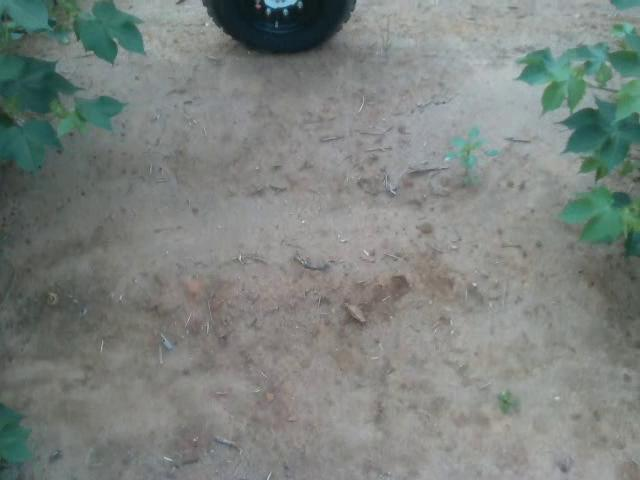

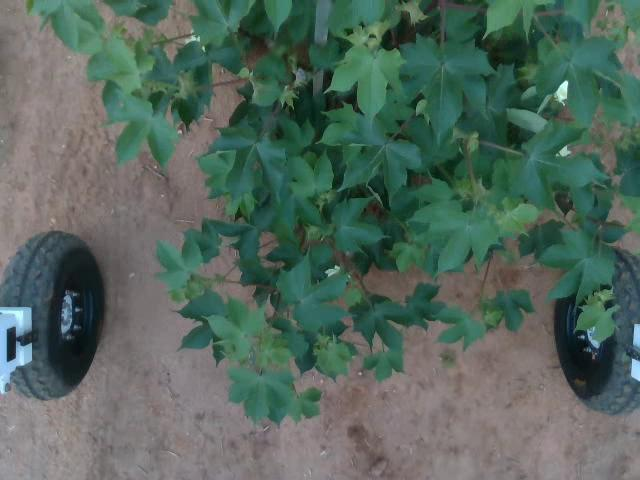

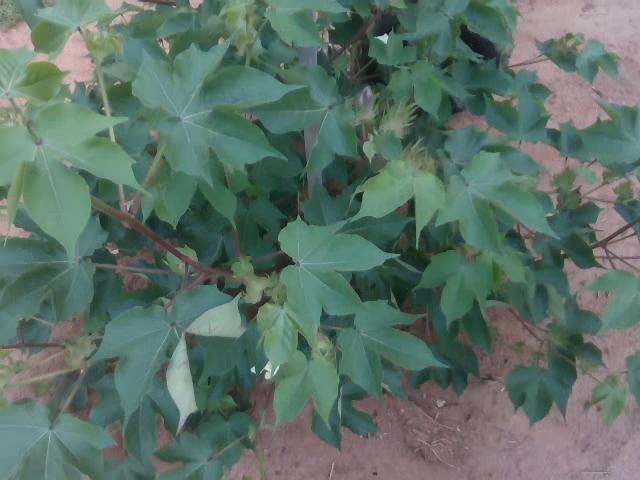

In [242]:
from PIL import Image

cam0, cam1, cam2 = dataset[2000]

display(Image.fromarray(cam0.permute((1, 2, 0)).numpy()))
display(Image.fromarray(cam1.permute((1, 2, 0)).numpy()))
display(Image.fromarray(cam2.permute((1, 2, 0)).numpy()))

In [243]:
import torch
from torchvision.transforms.functional import resize

cam0_ex = cam0[None, :, :, :].to(torch.float) / 255

with torch.no_grad():
    encoded = trained_model.encoder(cam0_ex)
encoded = torch.mean(encoded, dim=1, keepdims=True)
encoded -= torch.min(encoded)
encoded /= torch.max(encoded)
encoded = resize(encoded, (512, 512))

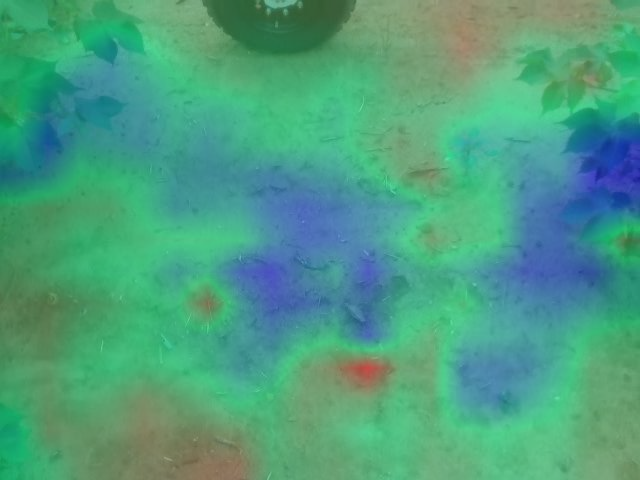

In [244]:
from self_supervised.pipelines.visualization import visualize_heat_maps

visualized_cam0 = visualize_heat_maps(images=cam0[None, :, :, :], features=encoded)

display(Image.fromarray(visualized_cam0[0].permute((1, 2, 0)).numpy()))

In [245]:
cam1_ex = cam1[None, :, :, :].to(torch.float) / 255
cam2_ex = cam2[None, :, :, :].to(torch.float) / 255

cam0_rep = trained_model(cam0_ex)[0]
cam1_rep = trained_model(cam1_ex)[0]
cam2_rep = trained_model(cam0_ex)[0]

cam0_rep = cam0_rep.detach()
cam1_rep = cam1_rep.detach()
cam2_rep = cam2_rep.detach()

In [246]:
import numpy as np

cam01_sim = torch.cosine_similarity(cam0_rep, cam1_rep, dim=1)
cam02_sim = torch.cosine_similarity(cam0_rep, cam2_rep, dim=1)
cam12_sim = torch.cosine_similarity(cam1_rep, cam2_rep, dim=1)
np.mean([cam01_sim.item(), cam02_sim.item(), cam12_sim.item()])

0.5545125404993693

In [247]:
# Check against another set of frames.
other_cam0, other_cam1, other_cam2 = dataset[20300]

In [248]:
other_cam0_ex = other_cam0[None, :, :, :].to(torch.float) / 255
other_cam1_ex = other_cam1[None, :, :, :].to(torch.float) / 255
other_cam2_ex = other_cam2[None, :, :, :].to(torch.float) / 255

other_cam0_rep = trained_model(other_cam0_ex)[0]
other_cam1_rep = trained_model(other_cam1_ex)[0]
other_cam2_rep = trained_model(other_cam0_ex)[0]

other_cam0_rep = other_cam0_rep.detach()
other_cam1_rep = other_cam1_rep.detach()
other_cam2_rep = other_cam2_rep.detach()

In [249]:
cam00_sim = torch.cosine_similarity(cam0_rep, other_cam0_rep, dim=1)
cam11_sim = torch.cosine_similarity(cam1_rep, other_cam1_rep, dim=1)
cam22_sim = torch.cosine_similarity(cam2_rep, other_cam2_rep, dim=1)
np.mean([cam00_sim.item(), cam11_sim.item(), cam22_sim.item()])

0.024617818494637806

In [250]:
cam01_sim = torch.cosine_similarity(other_cam0_rep, other_cam1_rep, dim=1)
cam02_sim = torch.cosine_similarity(other_cam0_rep, other_cam2_rep, dim=1)
cam12_sim = torch.cosine_similarity(other_cam1_rep, other_cam2_rep, dim=1)
np.mean([cam01_sim.item(), cam02_sim.item(), cam12_sim.item()])

0.7852525313695272

In [251]:
from self_supervised.pipelines.train_simclr.nodes import _collate_views
from torch.utils import data

data_loader = data.DataLoader(
        dataset,
        batch_size=8,
        collate_fn=_collate_views,
        pin_memory=True,
        num_workers=8,
        shuffle=True,
        drop_last=True,
    )
cam0_batch, cam1_batch, cam2_batch = next(iter(data_loader))

In [252]:
cam0_batch = torch.stack(cam0_batch).to(torch.float) / 255
cam1_batch = torch.stack(cam1_batch).to(torch.float) / 255
cam2_batch = torch.stack(cam2_batch).to(torch.float) / 255

cam0_batch = cam0_batch.detach()
cam1_batch = cam1_batch.detach()
cam2_batch = cam2_batch.detach()

with torch.no_grad():
    cam0_rep, cam1_rep, cam2_rep = trained_model(cam0_batch, cam1_batch, cam2_batch)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ ❱  1 cam0_batch = torch.stack(cam0_batch).to(torch.float) / 255                                  │
│    2 cam1_batch = torch.stack(cam1_batch).to(torch.float) / 255                                  │
│    3 cam2_batch = torch.stack(cam2_batch).to(torch.float) / 255                                  │
│    4                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: stack expects each tensor to be equal size, but got [3, 480, 640] at entry 0 and [3, 540, 960] at 
entry 1

In [ ]:
from self_supervised.pipelines.train_simclr.losses import compute_all_similarities

sim_01 = compute_all_similarities(cam0_rep, cam1_rep)

In [253]:
sim_01

tensor([[ 0.90070,  0.00829, -0.00886, -0.04044,  0.08395, -0.06589,  0.07924,  0.08774],
        [ 0.03898,  0.09094,  0.23043,  0.11893, -0.00713, -0.00839, -0.01857,  0.01860],
        [-0.05015,  0.16874,  0.38497,  0.20100,  0.00793, -0.04355,  0.16713, -0.01412],
        [-0.01698,  0.03643,  0.11891,  0.58509, -0.04548,  0.04703, -0.06355, -0.04763],
        [-0.01126,  0.04962, -0.01285, -0.02864,  0.69858,  0.04611,  0.01888,  0.07517],
        [-0.12321, -0.05116, -0.00349,  0.01181, -0.10367,  0.51672,  0.03238, -0.03226],
        [ 0.07222,  0.21531,  0.04477,  0.01288,  0.04460, -0.02330,  0.87553, -0.02426],
        [-0.01316, -0.06250,  0.12654,  0.04086,  0.04306, -0.08501,  0.07468,  0.70740]])

In [254]:
sim_01 >= 0.5

tensor([[ True, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False,  True, False, False, False, False],
        [False, False, False, False,  True, False, False, False],
        [False, False, False, False, False,  True, False, False],
        [False, False, False, False, False, False,  True, False],
        [False, False, False, False, False, False, False,  True]])